今天研究了SVM 使用hyper line的再多維空間的方法，因為使用linear是無法有效解決問題，因此使用nonlinear，而kernel default是使用RBF，這很適合使用在圖片辨識中，不適合使用在文字，另外SVM也可以解決多分類問題，用的方法是 one vs rest，EX:假設共五類要做分類，就把它分為第一類與其他類，第二次分類就是第二類與其他類，以此類推。

學習的影片是看
https://www.youtube.com/watch?v=XepiB1Xhf-4&index=22&list=PLGmd9-PCMLhZu9ll-3gM__pqL5khffpFz&t=0s

In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

Automatically created module for IPython interactive environment


# 列印出dataset下載的時間

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# 下載的dataset

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
lfw_people.images.shape

(1288, 50, 37)

In [5]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
n_features

1850

In [6]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
target_names.shape

(7,)

In [7]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


# split train test data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# PCA 降維

In [9]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.441s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s


In [10]:
print("Fitting the classifier to the training set")
t0 = time()
#尋找哪一種參數使用於SVM中最好
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#GridSearchCV這個函數的目的就是做窮舉法，並且將最好的參數show出來
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/home/letitgo/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 22.542s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [11]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

#classification_report可以將機器預測與實際的label做分析
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.93      0.79        14
     Colin Powell       0.71      0.77      0.74        52
  Donald Rumsfeld       0.82      0.89      0.85        35
    George W Bush       0.88      0.84      0.86       134
Gerhard Schroeder       0.71      0.71      0.71        24
      Hugo Chavez       0.94      0.77      0.85        22
       Tony Blair       0.78      0.76      0.77        41

        micro avg       0.81      0.81      0.81       322
        macro avg       0.79      0.81      0.79       322
     weighted avg       0.82      0.81      0.81       322

[[ 13   1   0   0   0   0   0]
 [  1  40   2   8   0   1   0]
 [  1   0  31   2   0   0   1]
 [  4   9   3 112   2   0   4]
 [  0   3   0   1  17   0   3]
 [  0   1   0   1   2  17   1]
 [  0   2   2   3   3   0  31]]


# 將圖用4*3畫出來

In [12]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [13]:
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# show出沒有降維過的image

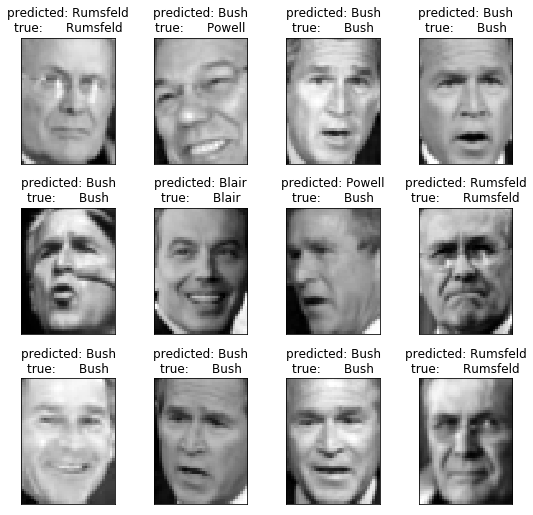

In [14]:
#透過下面的方法，將預測的label與實際的label做merge
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

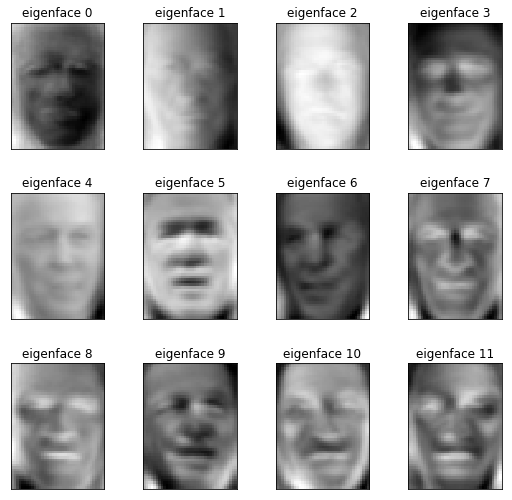

In [15]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()